In this notebook the definion of models using PyTorch `nn.Module`.
This method is important since most commonly, PyTorch models are not defined directly by operations such as `matmul`. Rather, higher level abstractions are used. These are the PyTorch `nn.Module`s, which wrap such lower-level operations, and adds a way more functionality (such as defining and initializing its own parameters). This is the default method to use when working with neural networks in PyTorch.

In this notebook we go back to the linear regression problem, and replace the functional definition of the model, with the `nn.Module` class, whole also  introducing the required changes downstream.

The key takeaways is:
1. Use the `nn` module to define the model and loss function

In [1]:
import torch
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import helpers as h
from math import floor, ceil

In [2]:
# Set the random seed for reproducibility
torch.manual_seed(42)

### Generating the Input Data
Each instance (data entry) represents a point in a two-dimensional space $(x_i,y_i)$. The data points are generated around a line defined by its slope and intercept with the y-axis (at $x=0$). The x-values are chosen randomly from a given range. The y-values are generated according to the $x$ and the linear equation, with a random uniform noise around it.   

In [3]:
NUMBER_OF_DATA_POINTS = 4
X_RANGE = {
    'min': 0.,
    'max': 2.
}
SLOPE = 3
INTERCEPT = 4
NOISE_RANGE = 1.5

def generate_data(
    x_range:dict[str, float]=X_RANGE,
    number_of_data_points:int=NUMBER_OF_DATA_POINTS,
    slope:float=SLOPE,
    intercept:float=INTERCEPT,
    noise_range:float=NOISE_RANGE
    ) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generates data for linear regression.
    """
    range = X_RANGE['max'] - X_RANGE['min']
    X = x_range['min'] + (range * torch.rand(size=(number_of_data_points, 1)))  # randomly-generated x-values, taken from a uniform distribution within `x_range`
    y = intercept + (slope * X) + (((torch.rand(size=(number_of_data_points, 1)) - 0.5) * 2) * noise_range)  # y-values with uniformaliy distributed noise added
    return X, y

X, y = generate_data()

In [4]:
h.print_tensor_info(X, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[1.7645],
        [1.8300],
        [0.7657],
        [1.9186]])
Dimension    2
Shape        (4, 1)


In [5]:
h.print_tensor_info(y, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[ 8.9650],
        [ 9.7927],
        [ 5.5669],
        [10.6368]])
Dimension    2
Shape        (4, 1)


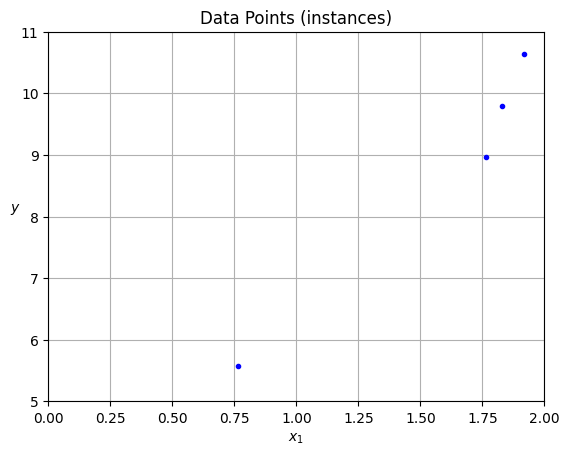

In [6]:
def plot_data_points(X, y):
    plt.plot(X, y.detach().numpy(), "b.")
    plt.xlabel("$x_1$")
    plt.ylabel("$y$", rotation=0)
    plt.title("Data Points (instances)")
    plt.axis([X_RANGE['min'], X_RANGE['max'], floor(y.min()), ceil(y.max())])
    plt.grid()
    plt.show()
    return

plot_data_points(X, y)

### Defining the Model
**Defining the model using the `nn` module is the first change we make compared to the previous notebook**
Notice that the parameters ($weight$ and $bias$) are defined as part of the model, and are initialized.

In [7]:
model = nn.Linear(in_features=1, out_features=1)

In [8]:
print(model)

Linear(in_features=1, out_features=1, bias=True)


In [9]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Parameter: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: Linear(in_features=1, out_features=1, bias=True)


Parameter: weight | Size: torch.Size([1, 1]) | Values : tensor([[0.8815]], grad_fn=<SliceBackward0>) 

Parameter: bias | Size: torch.Size([1]) | Values : tensor([-0.7336], grad_fn=<SliceBackward0>) 



In [10]:
def predict(X: torch.Tensor) -> torch.Tensor:
    """
    Calculates the value of the model, at points X.
    Parameters:
    ----------
    X: torch tensor of shape (number_of_points_to_predict, 1), representing the x-values of the points to predict
    Returns:
    -------
    y_predicted: a torch tensor of shape (number_of_points_to_predict, 1), representing the predicted y-values of the points according to the model
    """
    return model(X)

In [11]:
y_predicted = predict(X)

In [12]:
h.print_tensor_info(y_predicted, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[ 0.8219],
        [ 0.8796],
        [-0.0586],
        [ 0.9577]], grad_fn=<AddmmBackward0>)
Dimension    2
Shape        (4, 1)


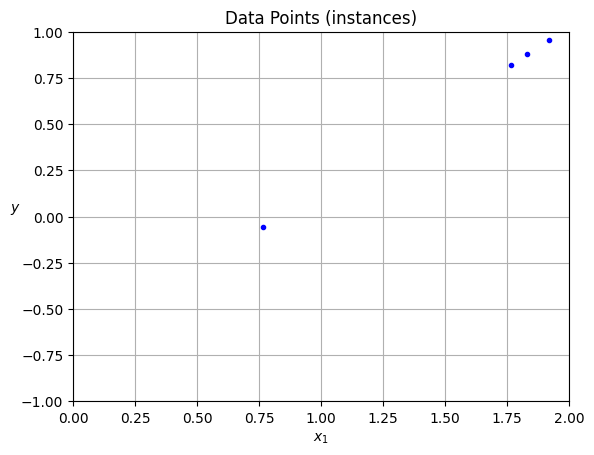

In [13]:
plot_data_points(X, y_predicted)

### Setting up a Loss Function

The loss function we are going to use is the mean squared error (MSE):

$\frac{1}{m}*\sum_{n=1} ^{m} (y_{predicted, n} - y_n)^2$

The `nn` module allows us to define the loss function as well, so this is the second change we introduce here

In [14]:
loss_fn = nn.MSELoss()
loss = loss_fn(y_predicted, y)

In [15]:
h.print_tensor_info(loss, fields=['Tensor', 'Dimension', 'Shape'])

67.77084350585938
Dimension    0
Shape        ()


### Optimization

In [16]:
lr = 0.01
print(f'Learning Rate: {lr:.4}')

Learning Rate: 0.01


In [17]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [18]:
def train_iteration(X, y, model, loss_fn, optimizer):
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [19]:
print('Epoch 0, Loss %f' % (float(loss.item())))
epochs = 100
for epoch in range(epochs):
    loss = train_iteration(X, y, model, loss_fn, optimizer)
    if (epoch+1) % 10 == 0:
            print('Epoch %d, Loss %f' % (epoch+1, float(loss.item())))
print("Done")

Epoch 0, Loss 67.770844
Epoch 10, Loss 17.658176
Epoch 20, Loss 4.083312
Epoch 30, Loss 1.065330
Epoch 40, Loss 0.393462
Epoch 50, Loss 0.243006
Epoch 60, Loss 0.208453
Epoch 70, Loss 0.199682
Epoch 80, Loss 0.196668
Epoch 90, Loss 0.194958
Epoch 100, Loss 0.193563
Done
